# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [34]:
import os
import warnings
from glob import glob

# Import new things that we'll need
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import nibabel as nb
import datetime

%matplotlib inline

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)

### I next want to get a list of all of my functional files

In [35]:
sid = ['01'] # sorry in my bids I labelled subject as 01, not 21
base_dir = '/home/fzaki001/Mattfeld_PSB6351/'
work_dir = '/home/fzaki001/scratch-bbr/psb6351/'
func_dir = os.path.join(base_dir, f'bids_dataset/sub-{sid[0]}/func')
fmap_dir = os.path.join(base_dir, f'bids_dataset/sub-{sid[0]}/fmap')
fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
assert len(func_json) > 0, "Check your bold json path! No files were found!"

func_files = sorted(glob(func_dir + '/*.nii.gz'))
assert len(func_files) > 0, "Check your bold scan path! No files were found!"

fmap_files = sorted(glob(fmap_dir + '/*bold*.nii.gz'))
assert len(fmap_files) > 0, "Check your bold fmap path! No files were found!"

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [3]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    assert len(func_files) > 0, "Input has no files!"
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

# HW3 - change the search window. how does this impact your results?
# ANSWER: It may impact the result such that
# if I increase the window it may find a volume with even less outliers and that volume may become the reference
# if it doesn't find any better volume, then nothing will change, because the function strives to take the earliest volume
# out of all "good" volumes
# if I decrease the window, I may not be able to find the volume with the least number of outliers
# if I shift the window (like 100:300) I may not only miss the volume with the least number of outliers
# but also miss the earliest volume with the least number of outliers
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information? 
# ANSWER: "SliceTiming" column, found it with visual inspection
####################################
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

In [19]:
# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(
    Function(
        input_names=['func_files'],
        output_names=['subs'],
        function=get_subs
    ),
    name='getsubs'
)
getsubs.inputs.func_files = func_files

In [5]:
# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume. I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(
    afni.OutlierCount(),
    name = 'id_outliers'
)
####################################
# HW3 - what happens if you chose a different func_file? How does it impact results
# Is the first func file the best way to go?
# ANSWER: It will search outliers in that file I specify
# If our goal is to find the volume with the least number of outliers, then I believe taking something from the 1st run
# is the way to go, because the subject is not tired yet
####################################
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 (changed to all available) volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(
    Function(
        input_names=['outlier_count'],
        output_names=['best_vol_num'],
        function=best_vol # this is the function we've defined before
    ),
    name='getbestvol' # this is the name we give to this part of the pipeline
)
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(
    fsl.ExtractROI(t_size=1),
    name = "extractref"
)
####################################
# HW3 - if you choose a different func file...should this change too?
# If yes, why? what should it change to? 
# ANSWER: If I choose another func file I will be searching for a reference
# volume to use the motion correction within that func file
# my understanding is that we should strive for choosing the run with the least possible amount of outliers
# that is probably the 1st run would work the best because the subject is not yet tired
# also as we can see further from the carpet plots 2nd and 3rd runs indeed appear to have more motion

# also it might be better to apply a motion correction separately to each run by taking reference volume from that run
# especially if between those runs the subject had breaks and moved
####################################
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

####################################
# HW3 - what happens when you change the order of the following two nodes?
# How does that impact your results?
# Run things again with the order reversed and save in a new sink folder without deleting your first
# ANSWER: I've tried doing that
# I saved all the plots from that run but I haven't noticed much difference in terms of plots
# there still were some outliers just like with the original run, just slightly in different places
# I recognize though that, if doing slice timing correction at all,
# perform it after motion correction (like in the original run) and that's why I put it back to that order
####################################
volreg = pe.MapNode(
    afni.Volreg(),
    iterfield=['in_file'],
    name = 'volreg',
)
volreg.inputs.outputtype = 'NIFTI_GZ'
volreg.inputs.zpad = 4
volreg.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter',)
tshifter.inputs.tr = '1.76'
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(volreg, 'out_file', tshifter, 'in_file')

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc_full/') # full means the run where I take all slices for outlier function
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')
psb6351_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')
psb6351_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')

In [52]:
# The following lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.run()

241012-21:49:06,934 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
241012-21:49:07,81 nipype.workflow INFO:
	 Running serially.
241012-21:49:07,105 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_outliers" in "/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/id_outliers".
241012-21:49:07,131 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.id_outliers" - collecting precomputed outputs
241012-21:49:07,132 nipype.workflow INFO:
	 [Node] "psb6351_wf.id_outliers" found cached.
241012-21:49:07,133 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.getsubs" in "/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/getsubs".
241012-21:49:07,150 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.getsubs" - collecting precomputed outputs
241012-21:49:07,150 nipype.workflow INFO:
	 [Node] "psb6351_wf.getsubs" found cached.
241012-21:49:07,152 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.g

### Now I will load and plot the motion files

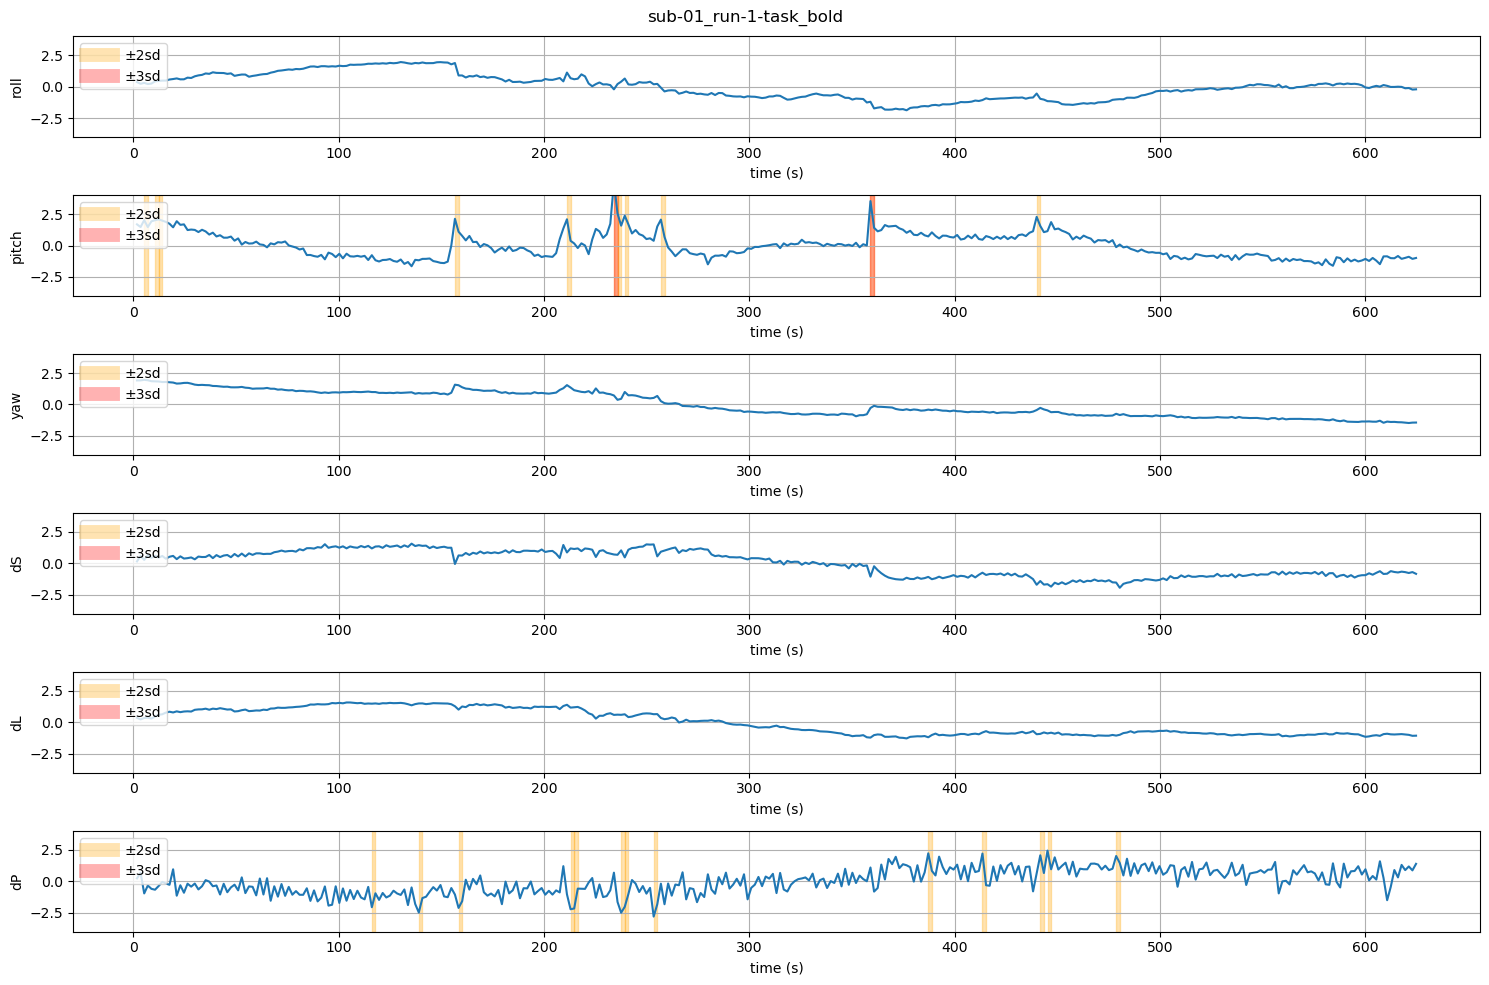

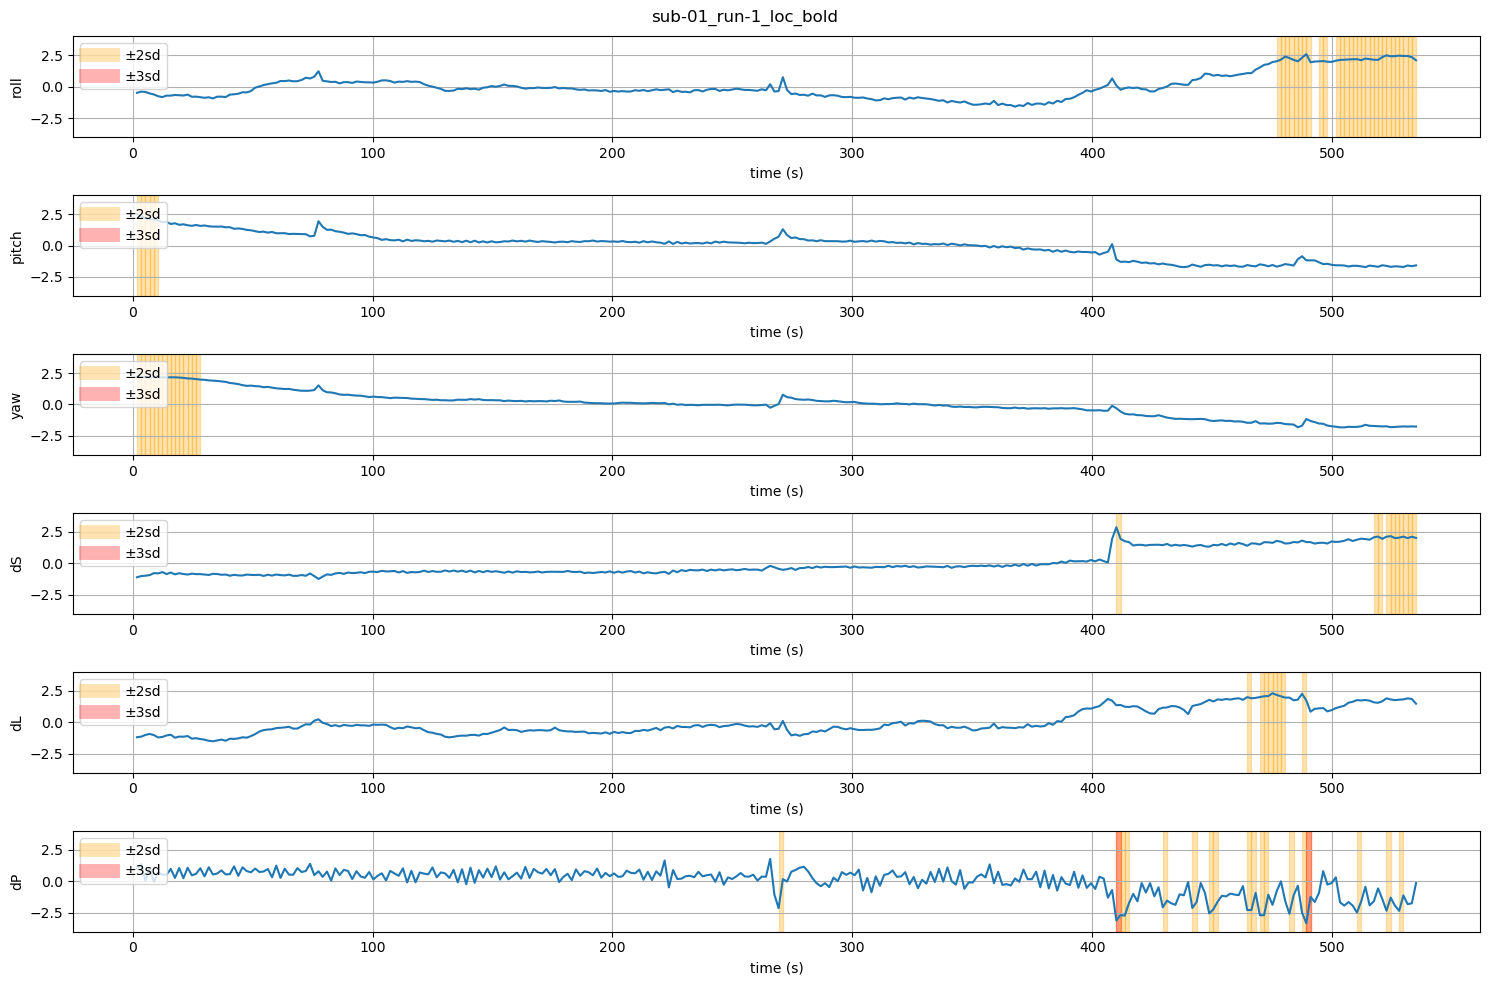

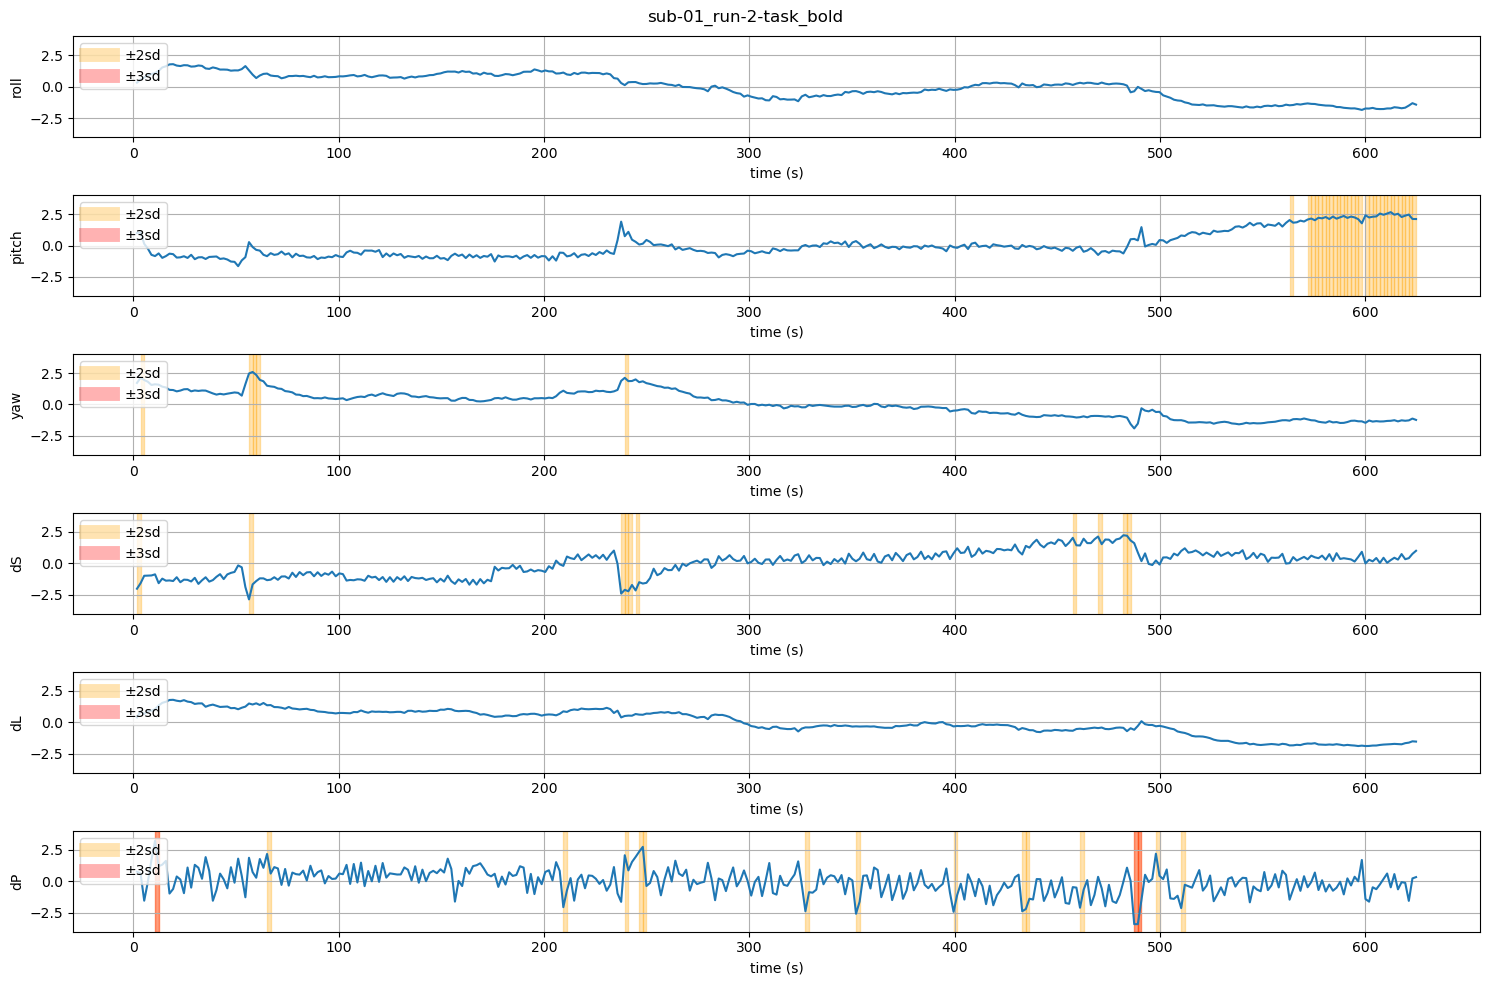

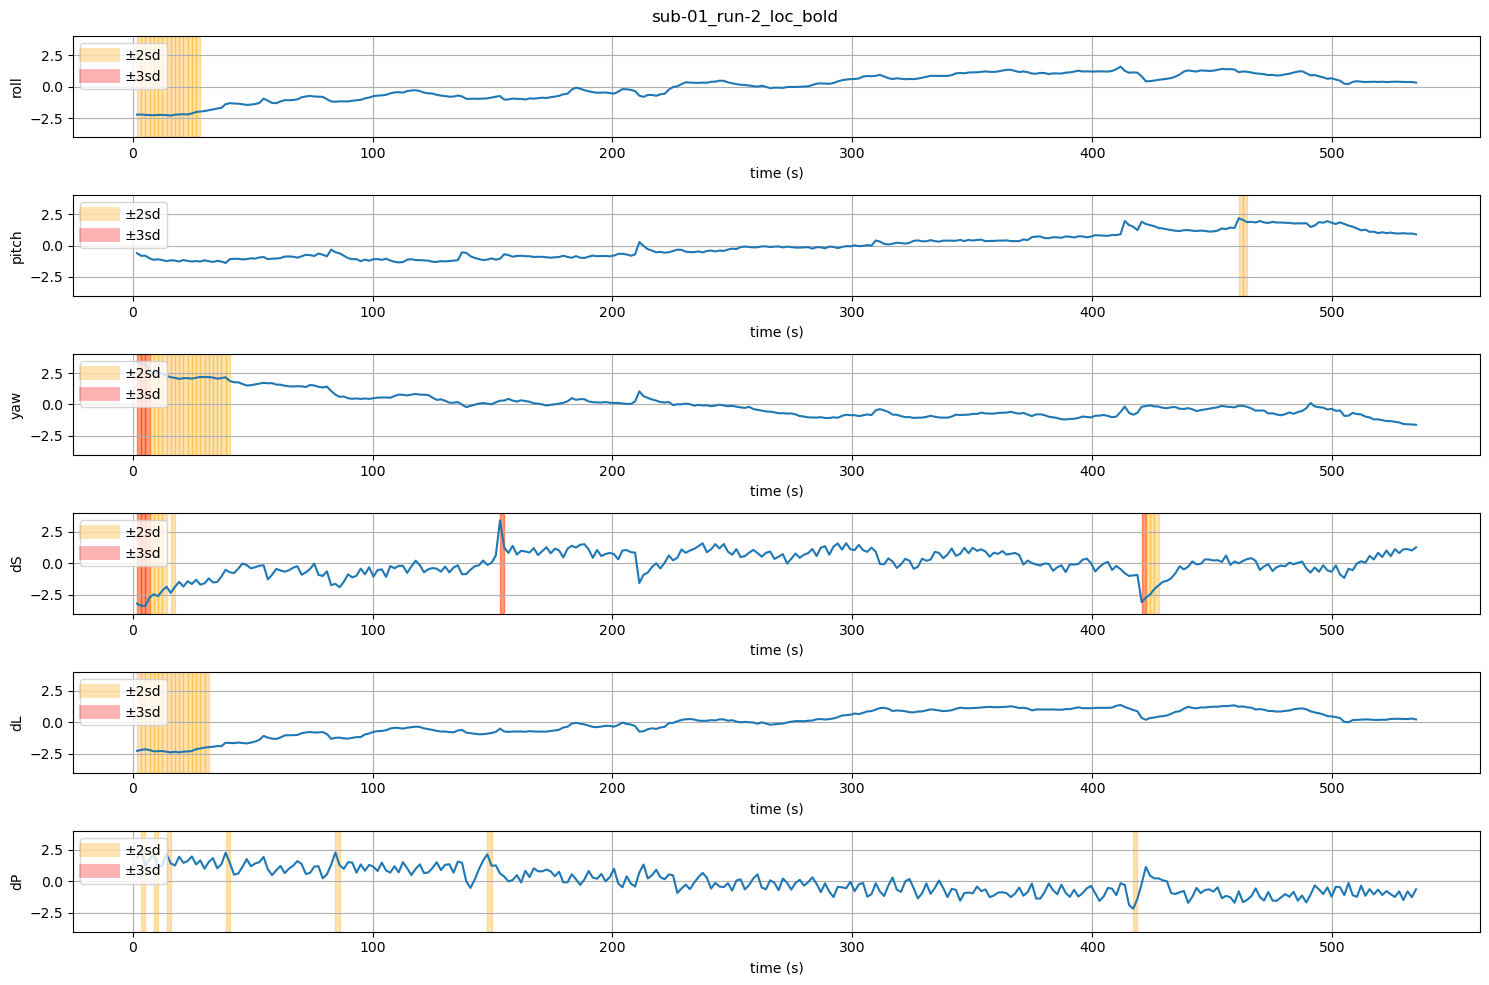

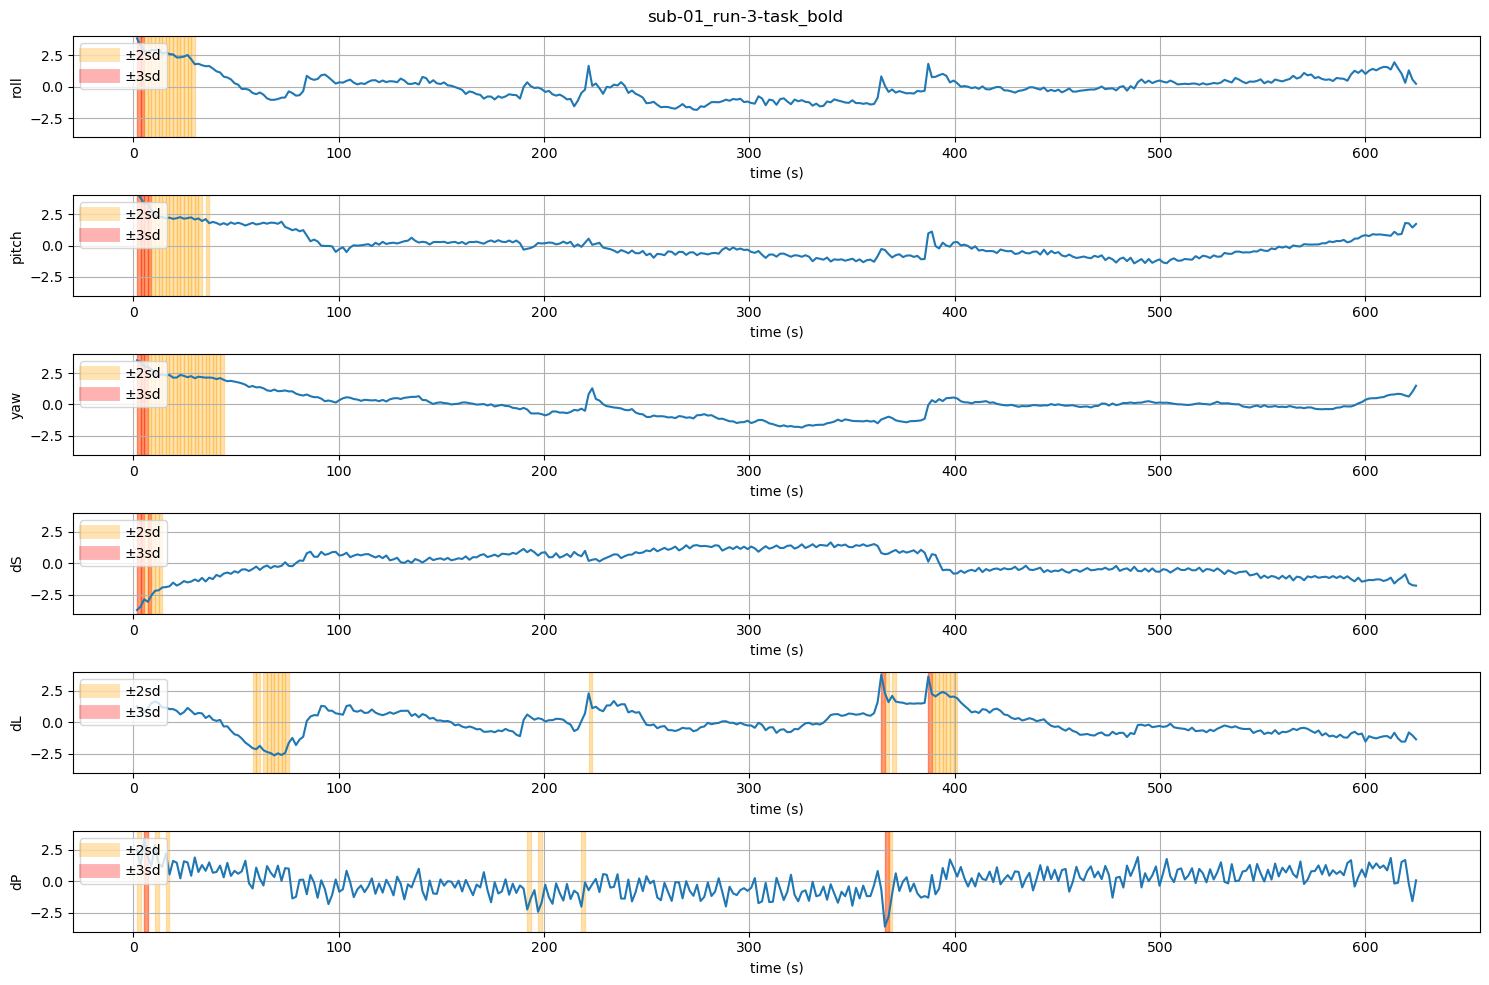

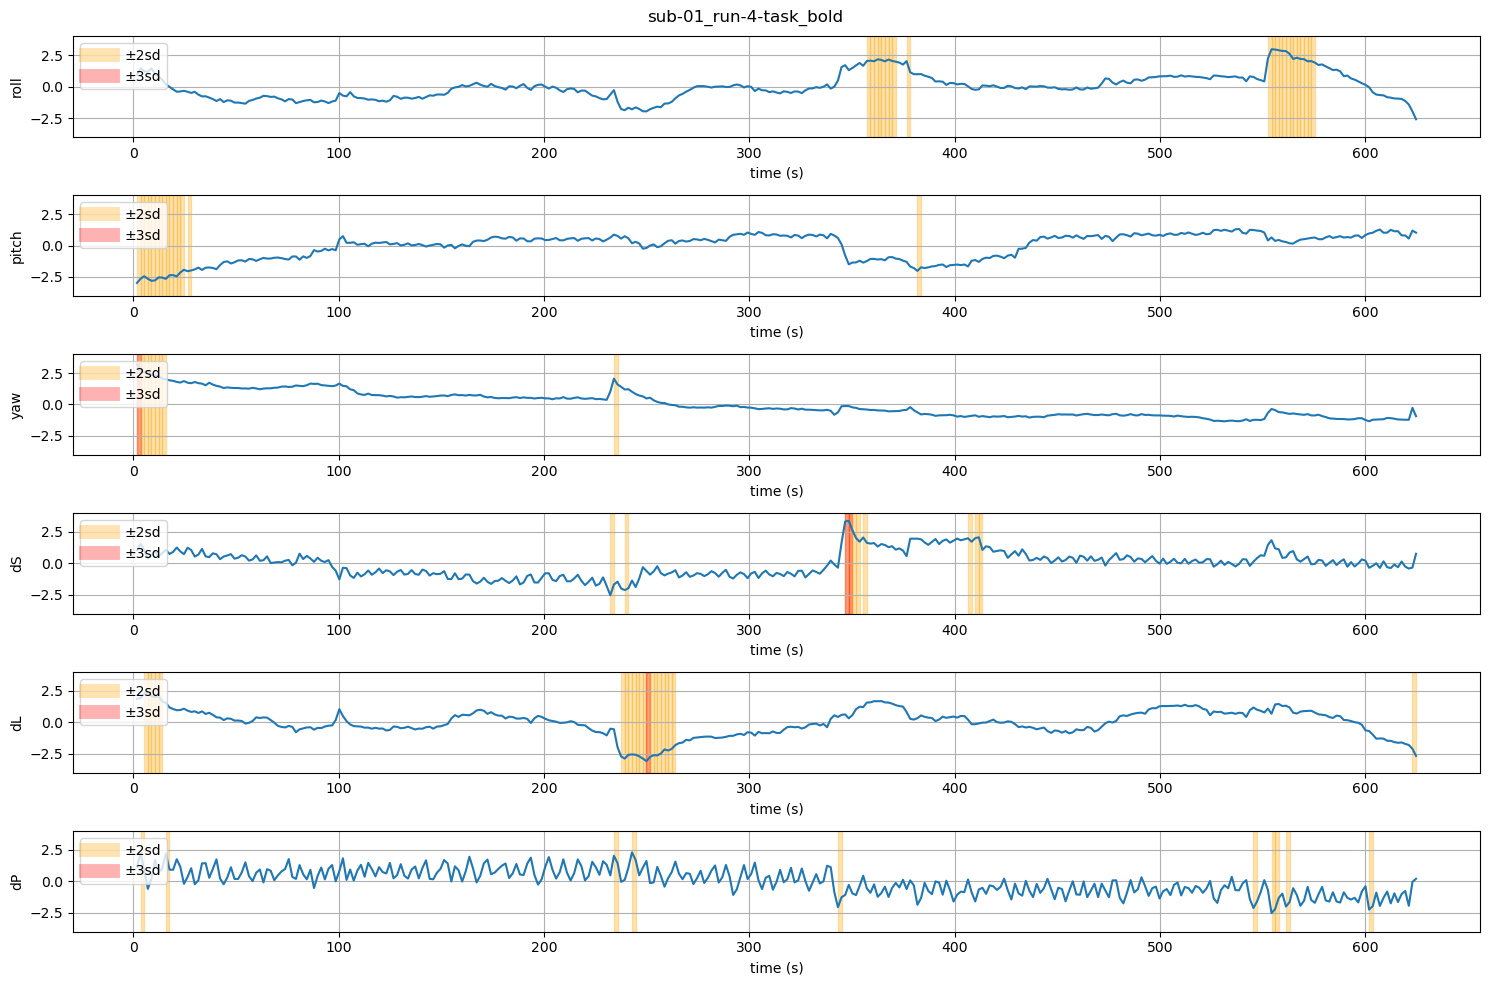

In [38]:
fig_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/figs'
motion_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/motion'
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))
# study_motion_files = sorted(glob(motion_dir + '/*_bold_tshift.1D')) # I needed this when reversed the order 
                                                                    # slice timing correction and motion correction

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df = (motion_df - motion_df.mean())/motion_df.std() # I'm not sure how common it is, but I standardized all motion values in all axes
                                                            # so that by visual inspection we can spot "significant outliers"
                                                            # and also have the same scale across all plots
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    filename = curr_mot_file.split('/')[-1].split('.')[0]
    fig.suptitle(filename)
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        data = motion_df[curr_col].values
        axs[idx].plot(
            [tr * 1.76 for tr in num_vols], # converted TR to time to make it more similar to the carpet plots below
            data,
        )
        axs[idx].set_xlabel('time (s)')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].legend(loc='upper left')
        axs[idx].set_ylim(-4, 4) # ylim applied to all plots to be able to set 2sd and 3sd thresholds
        axs[idx].grid(True)
    # plt.show()
        time = [tr * 1.76 for tr in num_vols]
        for i in range(len(data) - 1):
            if data[i] > 2 or data[i] < -2:
                axs[idx].axvspan(time[i], time[i + 1], color='orange', alpha=0.3, label = "±2sd")
            if data[i] > 3 or data[i] < -3:
                axs[idx].axvspan(time[i], time[i + 1], color='red', alpha=0.3, label = "±3sd")
        custom_lines = [
            Line2D([0], [0], color='orange', alpha=0.3, lw=10, label='±2sd'),
            Line2D([0], [0], color='red', alpha=0.3, lw=10, label='±3sd')
        ]
        axs[idx].legend(handles=custom_lines, loc='upper left')
        
    plt.tight_layout()
    plt.savefig(f"{fig_dir+'/'}{filename}_motion_tseries_{datetime.datetime.now()}.pdf")
    plt.show()

####################################
# HW3 - compare the motion parameter plots from this script to 
# the carpet plot below.  What is the relationship between large rotations and/or translations and the carpet plot
# reference specific TRs and their relation to time.
# ANSWER: I can see big outliers in the run3 at the dL axis at at 370-400s
# which seem to correspond to distortions on the corresponding carpet plot for that run
####################################

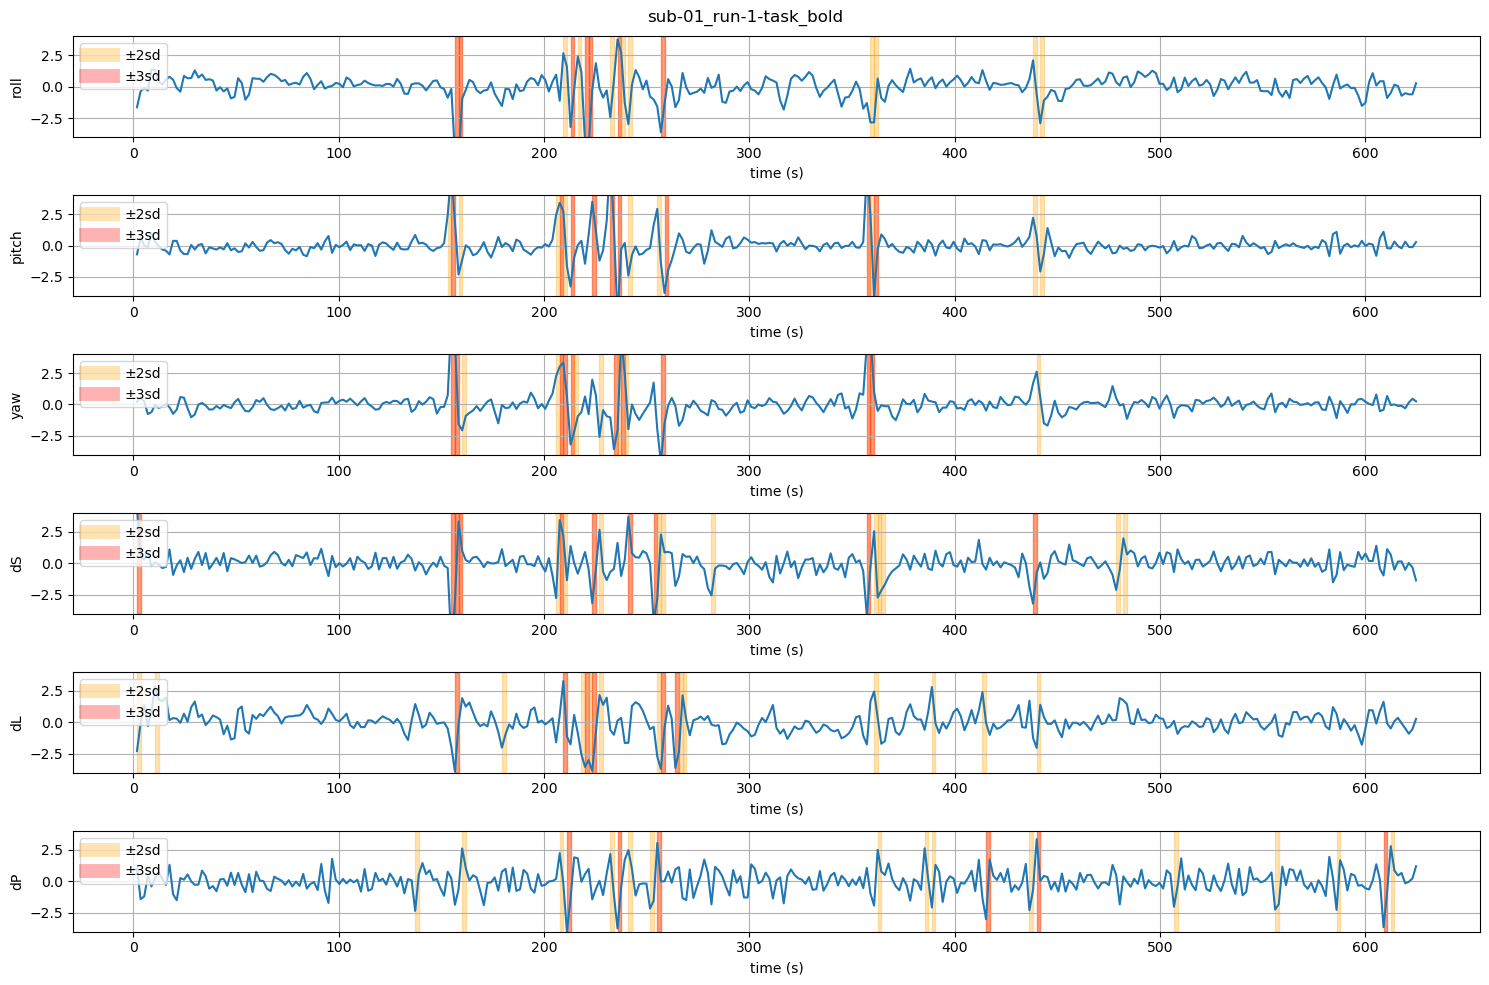

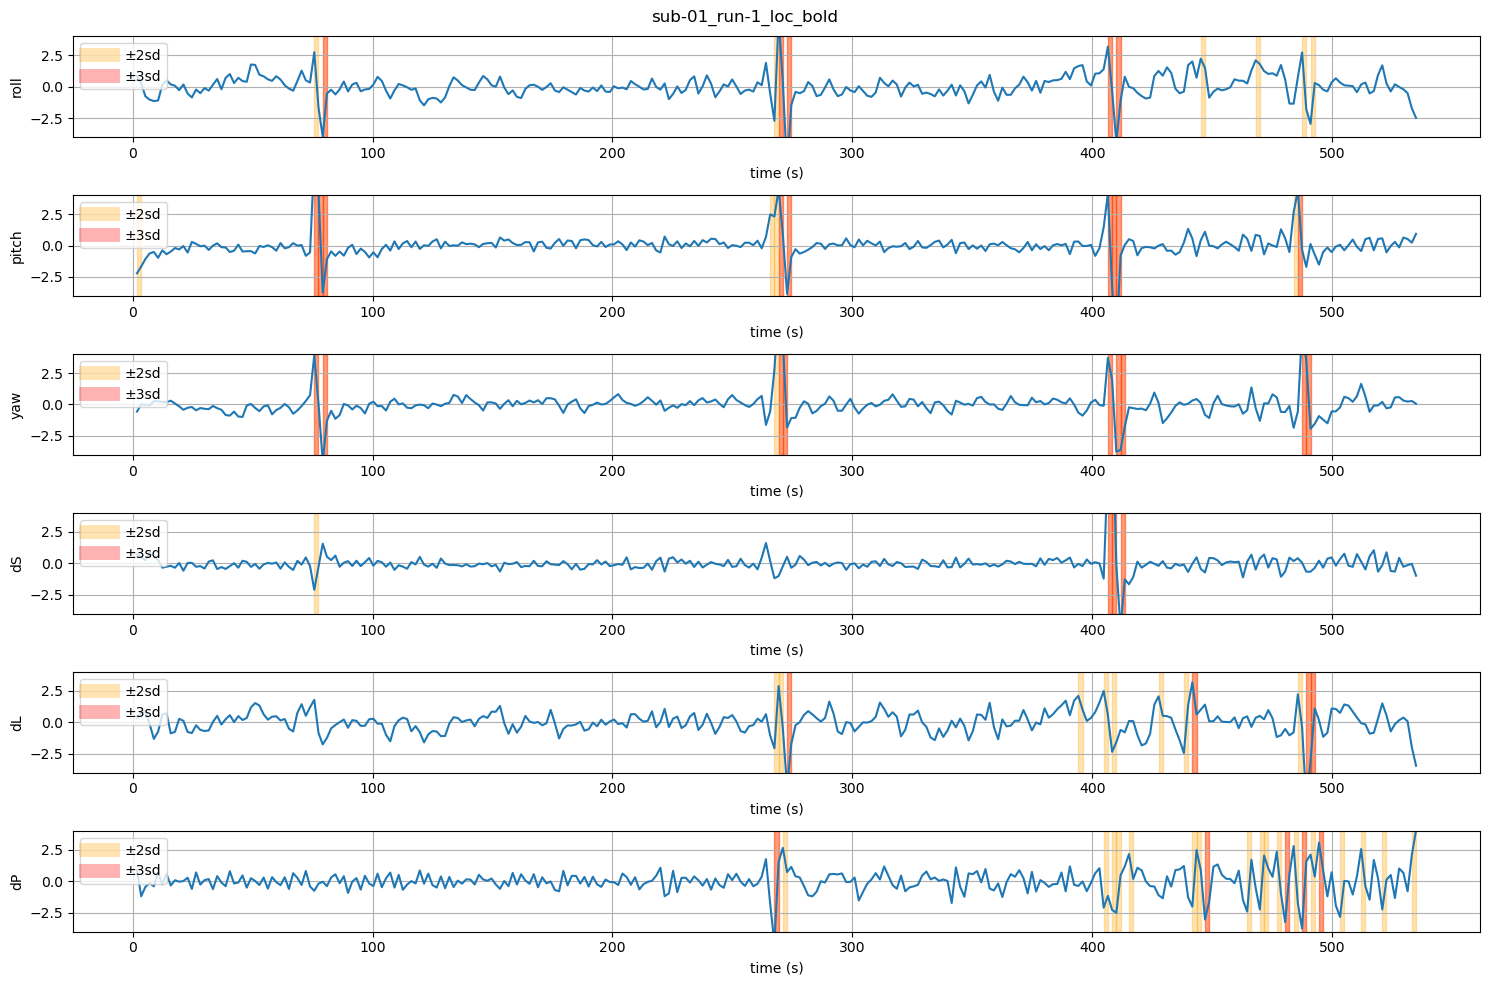

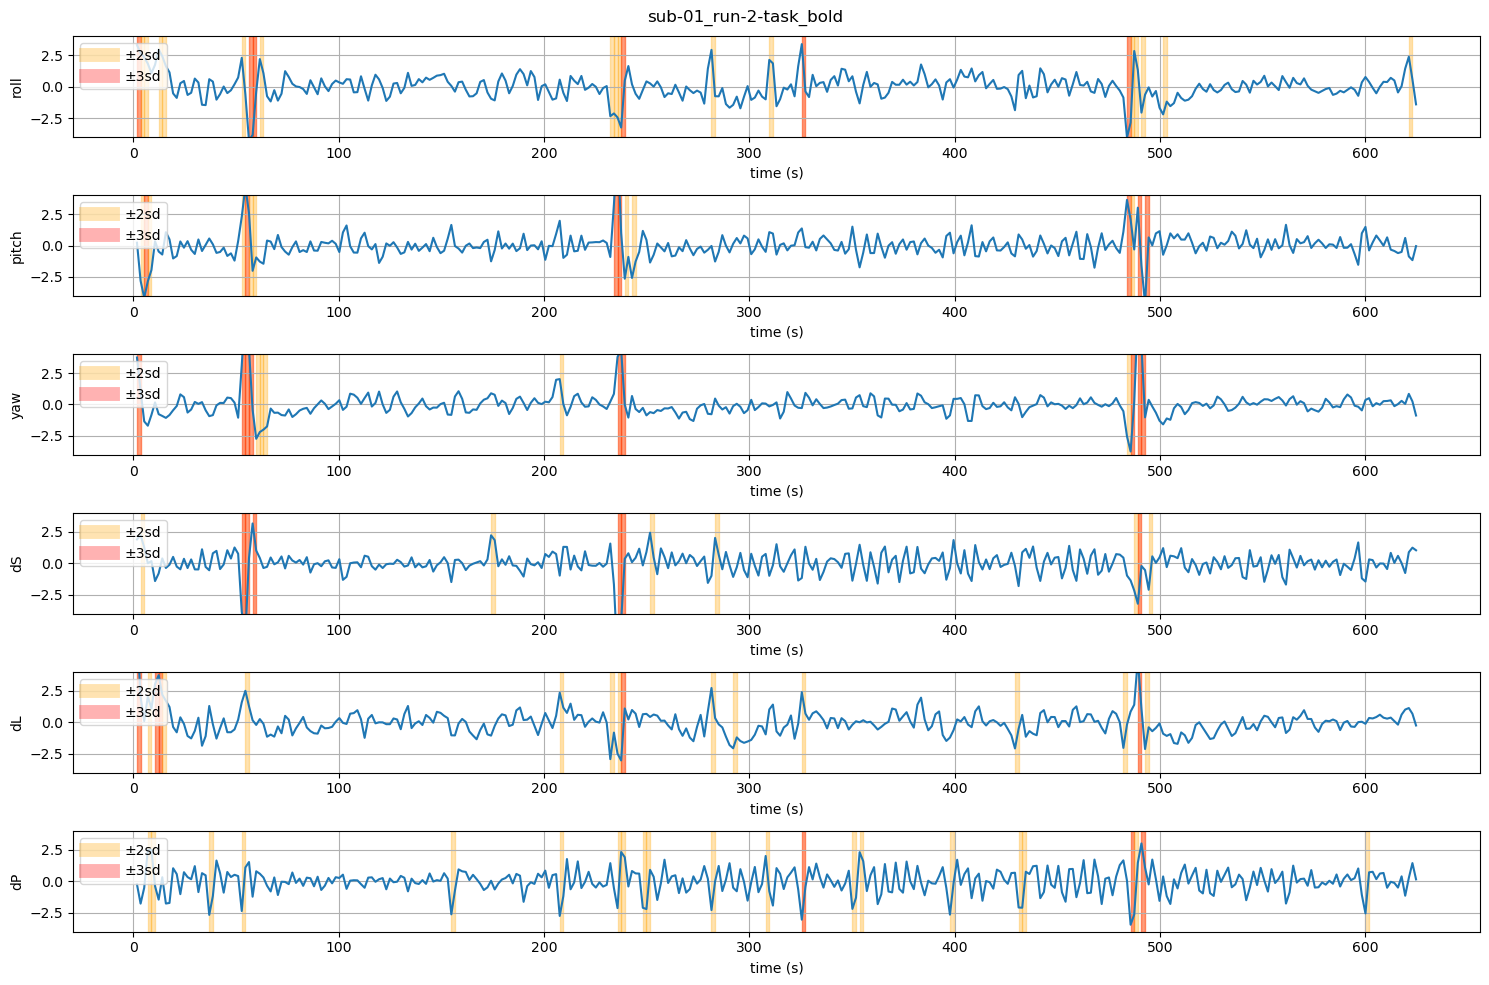

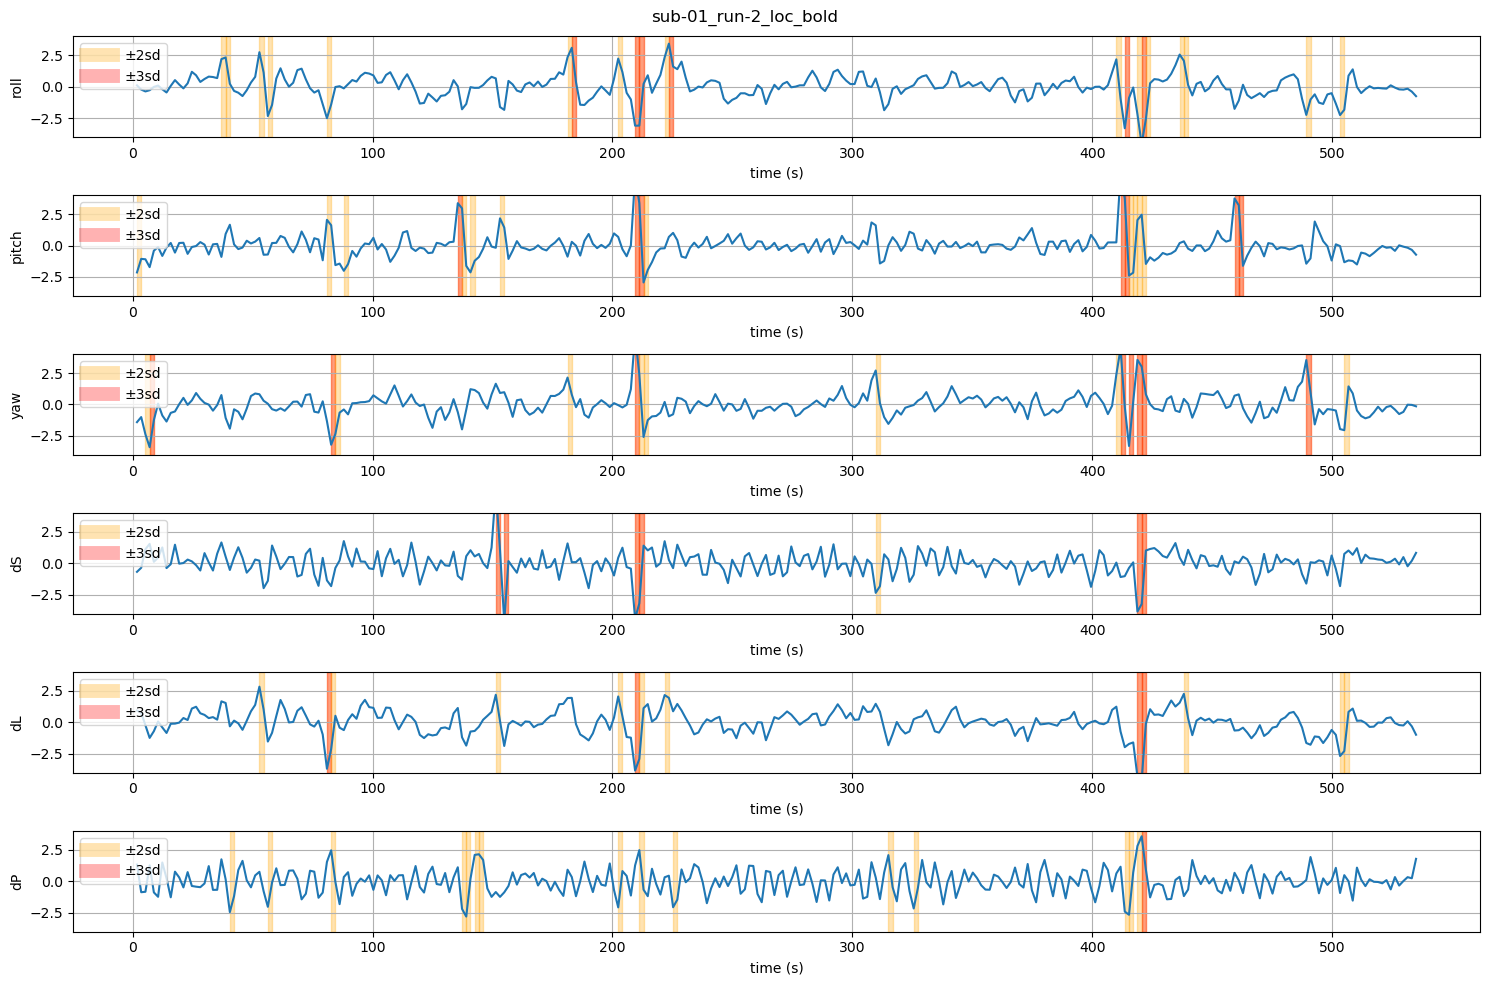

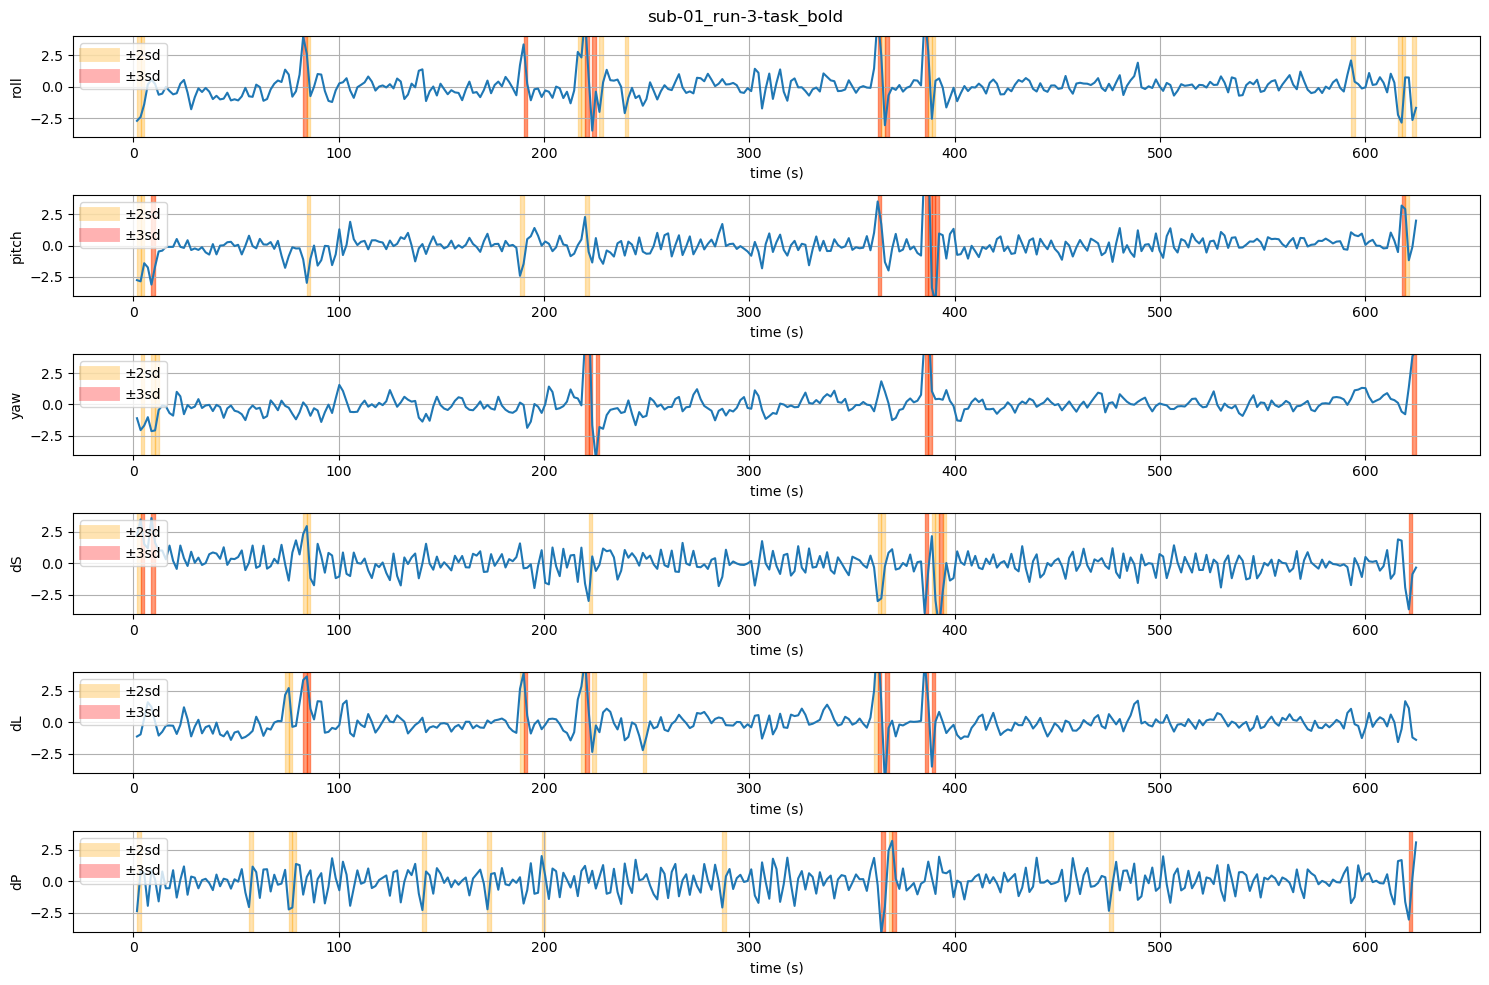

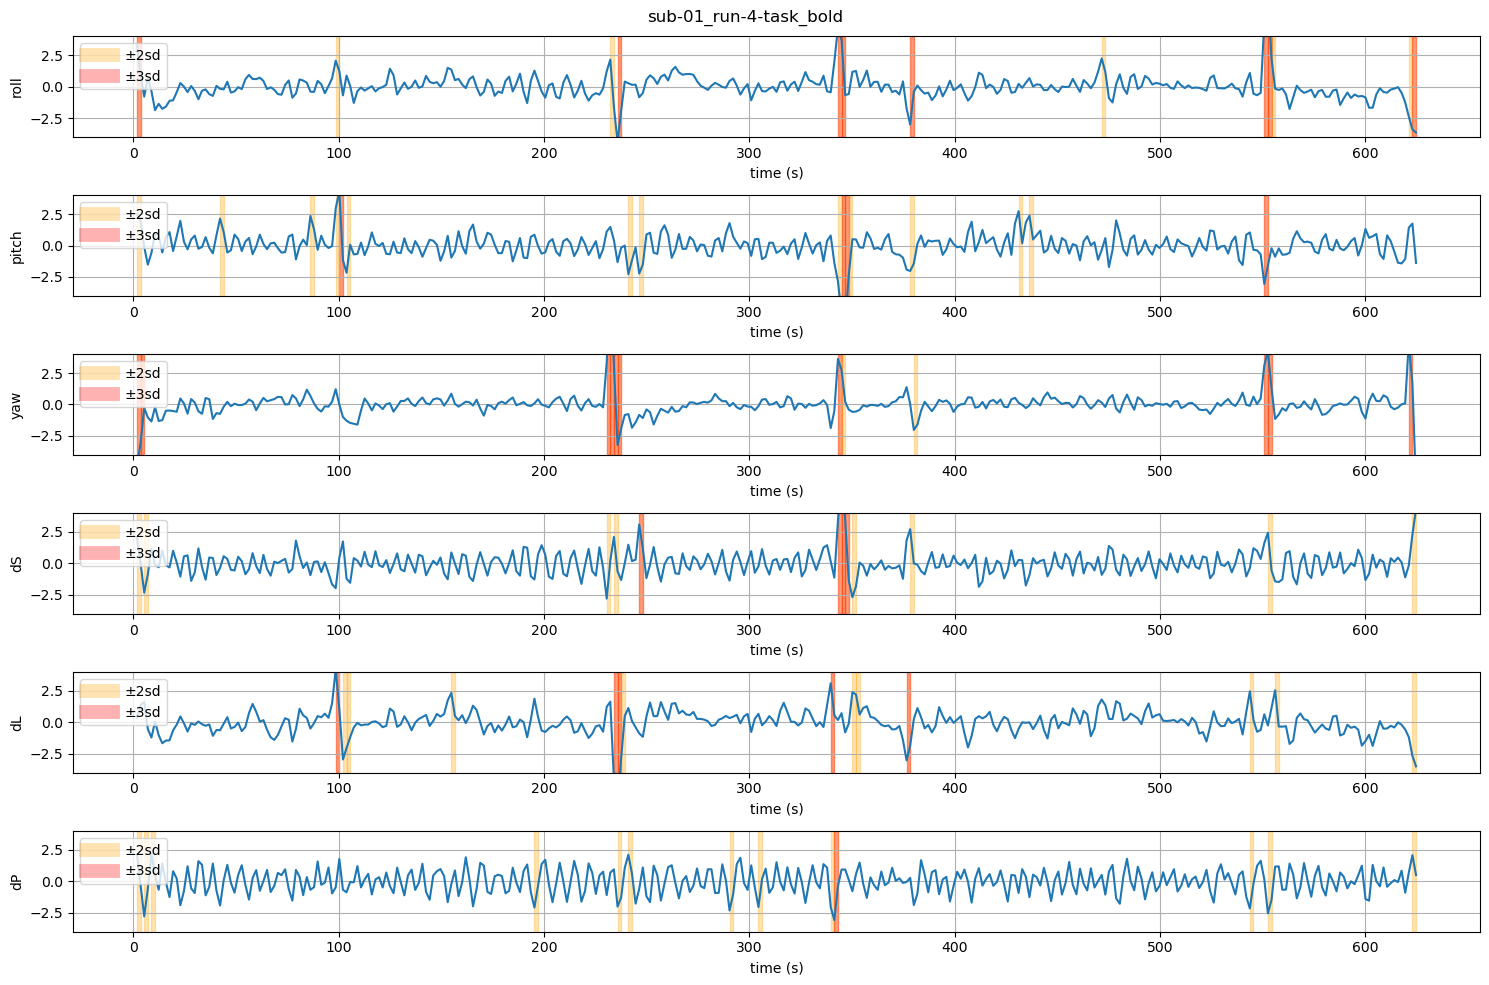

In [33]:
# here I also plot 1st derivative of motion parameters from above
# on these plots the peaks (in this case meaning the relative movement) can be seen better

fig_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/figs'
motion_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/motion'
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))
# study_motion_files = sorted(glob(motion_dir + '/*_bold_tshift.1D'))

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df = (motion_df - motion_df.mean())/motion_df.std()
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    filename = curr_mot_file.split('/')[-1].split('.')[0]
    fig.suptitle(filename)
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)
    for idx, curr_col in enumerate(motion_df.keys()):
        data = np.gradient(motion_df[curr_col].values) # compute derivative
        data = (data - np.mean(data)) / np.std(data) # standardize again
        axs[idx].plot(
            [tr * 1.76 for tr in num_vols],
            data,
        )
        axs[idx].set_xlabel('time (s)')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].legend(loc='upper left')
        axs[idx].set_ylim(-4, 4)
        axs[idx].grid(True)
        time = [tr * 1.76 for tr in num_vols]
        for i in range(len(data) - 1):
            if data[i] > 2 or data[i] < -2:
                axs[idx].axvspan(time[i], time[i + 1], color='orange', alpha=0.3, label = "±2sd")
            if data[i] > 3 or data[i] < -3:
                axs[idx].axvspan(time[i], time[i + 1], color='red', alpha=0.3, label = "±3sd")
        custom_lines = [
            Line2D([0], [0], color='orange', alpha=0.3, lw=10, label='±2sd'),
            Line2D([0], [0], color='red', alpha=0.3, lw=10, label='±3sd')
        ]
        axs[idx].legend(handles=custom_lines, loc='upper left')
        
    plt.tight_layout()
    # plt.savefig(f"{fig_dir+'/'}{filename}_motion_tseries_{datetime.datetime.now()}.png")
    plt.show()

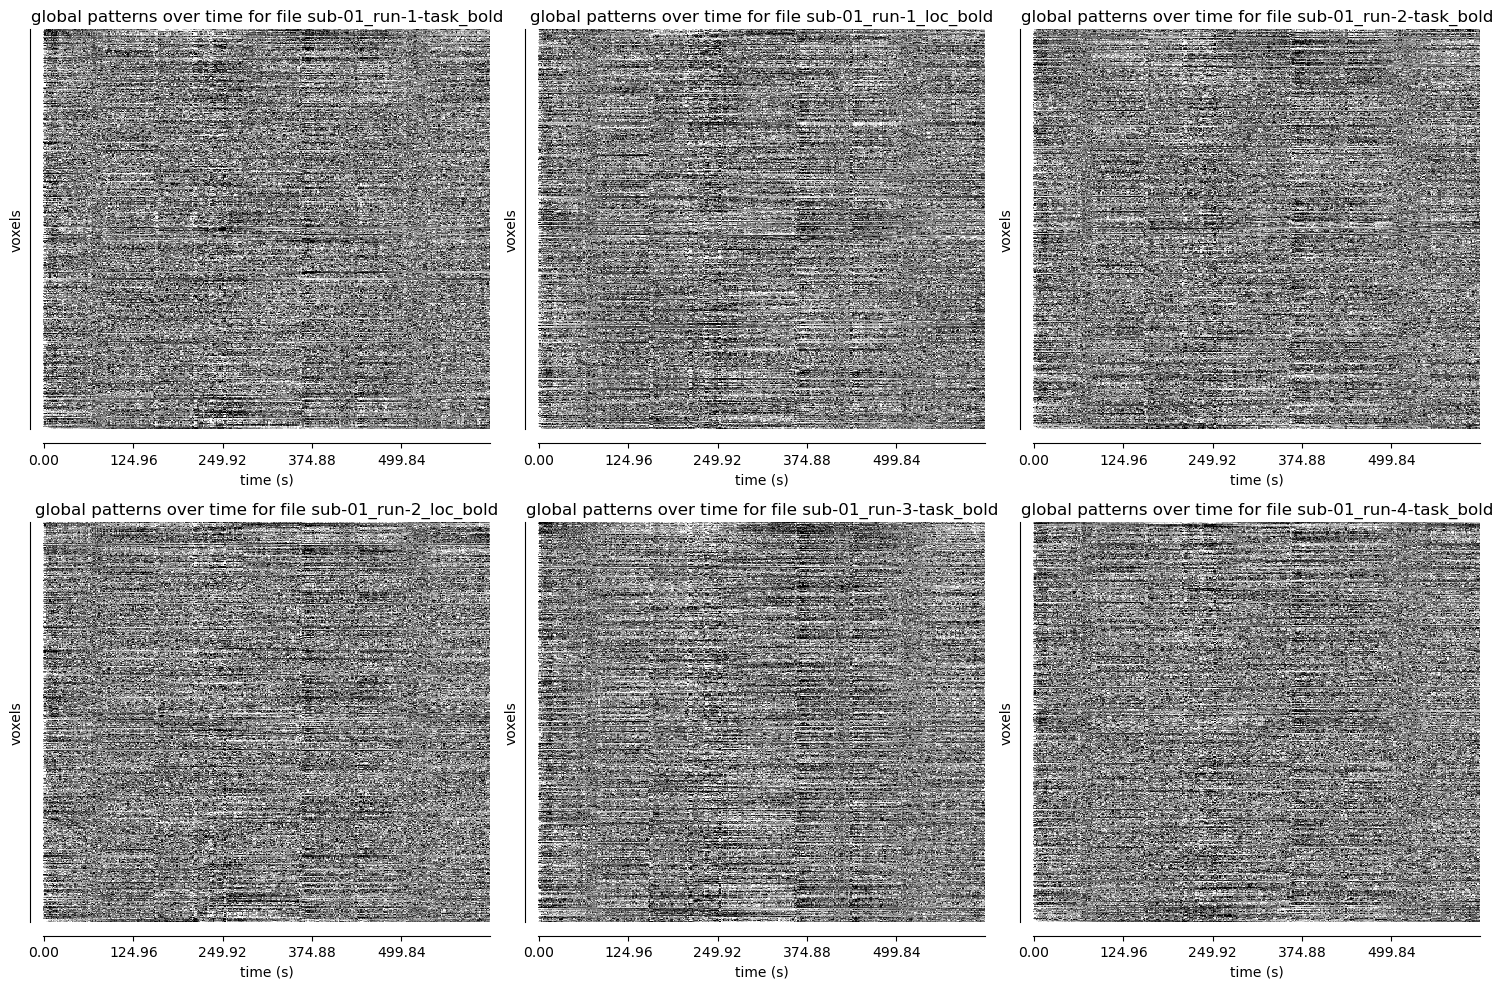

In [54]:
from nilearn.plotting import plot_carpet
from nilearn import masking

# Build an EPI-based mask because we have no anatomical data

####################################
# HW3 - compare different func files and their carpet plots
# which one are we looking at here? Which func file has the 
# most visually striking motion related changes in voxel intensity?
# ANSWER: If I understand correctly, task2 and task3
# appear to have more motion (can be seen the best at ~370s)
####################################

num_files = len(func_files)
num_cols = 3 
num_rows = (num_files + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, func_file in enumerate(func_files):
    mask_img = masking.compute_epi_mask(func_file)
    
    display = plot_carpet(
        func_files[0],
        mask_img,
        t_r=1.76,
        standardize="zscore_sample",
        title=f"global patterns over time for file {func_file.split('/')[-1].split('.')[0]}",
        axes=axes[i],
    )
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(f"{fig_dir+'/'}carpet_plots_{datetime.datetime.now()}.png")
plt.show()

# Save my work

In [37]:
import PyPDF2
import os
from pathlib import Path
from glob import glob

In [38]:
def merge_pdfs(filepaths, output_path):
    merger = PyPDF2.PdfMerger()
    
    for filepath in filepaths:
        merger.append(filepath)
    
    with open(output_path, 'wb') as output_file:
        merger.write(output_file)

In [39]:
path = "/home/fzaki001/Mattfeld_PSB6351/derivatives/preproc"
runs = ["", "_full", "_rev"] # "" means original run;
                            # full means with all slices for outlier functions;
                            # rev means reverse slice timing correction and motion correction
for run in runs:
    fig_list = sorted(
        sorted(
                [p for p in Path(path+run+"/sub-01/figs/").iterdir() if (p.name.endswith('.pdf')) and ("task" in p.name)],
                key=os.path.getatime)[:4] # save only regular motion plots for 4 task runs
    )
    output_path = f"/home/fzaki001/Mattfeld_PSB6351/pdf/motion{run}.pdf"
    merge_pdfs(fig_list, output_path)